# VASCA result analysis example TDS
### Example notebook to have a look at the results of 'vasca_pipe -cfg ../vasca_cfg.yaml' from the examples folder. The output of the pipline was stored in the folder vasca_pipeline.

In [1]:
# General path setup and library loading
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from jdaviz import Imviz
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as uu
from astropy.table import Table
from astropy.io import fits


from loguru import logger

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.utils import mag2flux

region_name = "TDS_ELAISN1"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"

### Basic region information

In [2]:
rg = Region()
rg.load_from_fits(region_fname)
display(rg.tt_fields)
sel_srcs = rg.tt_sources["sel"]
display(rg.tt_sources[sel_srcs])
#rg.info() # Show available tables

field_id,name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id
,,deg,deg,,,deg,,,s,d,d,
bytes22,bytes22,float64,float64,bytes22,bytes22,float32,bool,int32,float32,float64,float64,int32
GNU2597312684324028416,PS_ELAISN1_MOS10,242.50638203682297,55.9801443588634,GALEX,NUV,1.2,True,24,29566.4,54960.17787037037,56821.33210648148,0
GNU2597383053068206080,PS_ELAISN1_MOS11,244.57200462478102,55.1825511621234,GALEX,NUV,1.2,True,25,31369.5,54960.24638888889,56815.50054271557,1
GNU2597453421812383744,PS_ELAISN1_MOS12,242.896209389035,55.0003489374844,GALEX,NUV,1.2,True,21,26349.451,54960.314884259256,56814.569061234084,2
GNU2597523790556561408,PS_ELAISN1_MOS13,241.28881797574297,55.3529870930308,GALEX,NUV,1.2,True,22,27810.902,54960.38337962963,56819.53759259259,3
GNU2597594159300739072,PS_ELAISN1_MOS14,243.95513153083402,54.1978605194106,GALEX,NUV,1.2,True,22,26881.852,54960.451886574076,56810.60611111111,4
GNU2597664528044916736,PS_ELAISN1_MOS15,242.396514585217,53.9999872930018,GALEX,NUV,1.2,True,22,28044.65,54960.52040509259,56810.67461805556,5
GNU2597734896789094400,PS_ELAISN1_MOS16,241.37385712300306,54.4519391954855,GALEX,NUV,1.2,True,21,26780.799,54960.588912037034,56807.7931854022,6


fd_src_id,nr_det,nr_uls,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,flux_dmaxabs,flux_sigmax,flux_sigmax_dflux,flux_skew,mag,mag_err,sel,rg_fd_id,rg_src_id,nr_fd_srcs
,,,deg,deg,deg,deg2,deg2,,,1e-06 Jy,1e-06 Jy,1e-12 Jy2,1e-12 Jy2,,,1e-06 Jy,,1e-06 Jy,1e-12 Jy2,mag,mag,,,,
int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int32,int32,int32
-1,30,0,243.60753699448557,54.63795112496351,5.7688343e-05,-2.666058e-13,7.193411e-08,6.6799475e-05,1.5658976,4.550031,0.13781577,0.06669048,2.019733,2.1752783e-08,3.153394,2.9815335,2.9461772,1.9110196,0.3000138,22.254963,0.032396317,True,-1,537,2
-1,22,0,243.24725420177063,54.25117794242343,5.3781747e-05,-4.4898327e-13,4.084025e-08,0.007969039,1.3468169,23.719757,0.2582642,0.03195415,19.540436,1e-45,12.954728,8.924637,6.2873178,6.365696,0.12969771,20.462225,0.011758804,True,-1,856,2
-1,41,0,243.05228062657014,54.160204037969315,3.528358e-05,-1.1541605e-12,2.8213389e-08,0.0017106503,1.2198576,47.5953,0.23049355,0.055610828,128.30342,0.0,50.766243,22.743088,13.234659,20.814514,0.7240085,19.706089,0.0052452087,True,-1,1252,2
-1,22,0,243.05111323011315,54.25985947784263,6.754302e-05,-1.181997e-12,5.795727e-08,0.06741903,1.0777006,4.579896,0.15881996,0.20765842,4.974887,1.3370595e-21,7.172515,5.6998186,6.857331,5.6998186,1.209843,22.24786,0.0370121,True,-1,1254,2
-1,35,0,242.6581190813776,55.45413244109662,4.2004314e-05,-6.553211e-13,4.3735426e-08,3.4669813e-06,1.6190909,32.319218,0.22803906,0.017376108,20.151669,0.0,11.29161,7.172653,5.4343996,6.025339,-0.25395116,20.126347,0.007633209,True,-1,1467,2
-1,34,0,242.58471084185297,54.505337671199015,4.3662556e-05,-1.4113419e-12,4.128397e-08,8.968791e-05,1.4205985,16.453085,0.1781321,0.053072806,15.514129,0.0,13.774238,7.2251797,6.2461977,7.2251797,0.15290138,20.859383,0.011692047,True,-1,1518,2
-1,38,0,242.54903288742833,55.467625658786375,4.5301524e-05,-1.3491714e-12,5.8619175e-08,1.6087108e-07,1.6678174,8.205434,0.13810344,0.024753168,2.4392831,4.376986e-09,2.9575472,3.6160116,4.041878,3.6160116,0.5453239,21.614746,0.01812172,True,-1,1538,2
-1,20,0,242.52819083267553,54.54518914821429,6.2754356e-05,-3.0756814e-12,5.0658613e-08,0.00031061436,1.4511265,8.10785,0.19609714,0.042560127,3.6321094,4.6169005e-10,4.3943086,4.684519,4.169173,4.684519,0.54861754,21.627735,0.025945663,True,-1,1551,2


### Basic info source TDE PS1-10jh

Found VASCA source is at distance: 0.0002980595119041921 deg


field_id,name,ra,dec,observatory,obs_filter,fov_diam,sel,nr_vis,time_bin_size_sum,time_start,time_stop,rg_fd_id,fd_src_id
,,deg,deg,,,deg,,,s,d,d,,
bytes22,bytes22,float64,float64,bytes22,bytes22,float32,bool,int32,float32,float64,float64,int32,int32[1]
GNU2597664528044916736,PS_ELAISN1_MOS15,242.396514585217,53.9999872930018,GALEX,NUV,1.2,True,22,28044.65,54960.52040509259,56810.67461805556,5,2886


fd_src_id,nr_det,nr_uls,ra,dec,pos_err,pos_nxv,pos_var,pos_cpval,pos_rchiq,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,flux_dmaxabs,flux_sigmax,flux_sigmax_dflux,flux_skew,mag,mag_err,sel,rg_fd_id,rg_src_id,nr_fd_srcs
,,,deg,deg,deg,deg2,deg2,,,1e-06 Jy,1e-06 Jy,1e-12 Jy2,1e-12 Jy2,,,1e-06 Jy,,1e-06 Jy,1e-12 Jy2,mag,mag,,,,
int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int32,int32,int32
-1,9,0,242.36799404959558,53.67349280614587,8.930591e-05,-3.5977504e-12,2.4742178e-08,0.32532245,0.7638977,7.956288,0.26963854,10.739777,680.8981,0.0,297.64703,63.837864,37.623238,63.837864,1.7237443,21.648224,0.03618622,True,-1,48618,1


vis_id,fd_src_id,ra,dec,pos_err,flux,flux_err,s2n,sel,rg_fd_id,rg_src_id
,,deg,deg,deg,1e-06 Jy,1e-06 Jy,,,,
int64,int32,float64,float64,float32,float32,float32,float32,bool,int32,int32
2597664391209943040,2886,242.36794187408043,53.67332903707245,0.00019463737,5.9253736,0.75601786,7.8376107,True,5,48618
2597664391075725312,2886,242.3681994542763,53.67353780851961,0.0001389,71.79415,1.696767,42.31232,True,5,48618
2597664391142834176,2886,242.3678646423442,53.67336978366317,0.00019201534,5.4714675,0.69646895,7.8560104,True,5,48618
2597664391176388608,2886,242.3678701766545,53.67354550274539,0.00019144872,6.193512,0.7272987,8.515776,True,5,48618
2597664391344160768,2886,242.36820101585513,53.67362779732314,0.00023043352,2.3334231,0.65552974,3.5595992,True,5,48618
2597664391277051904,2886,242.36793383819526,53.673376313246045,0.00019170638,5.0972424,0.8218123,6.2024417,True,5,48618
2597664391243497472,2886,242.36809043633627,53.673386801808135,0.00018881161,5.6501956,0.7712134,7.326371,True,5,48618
2597664390975062016,2886,242.36807120218452,53.67364529001413,0.00014597736,54.91735,1.6375269,33.536762,True,5,48618


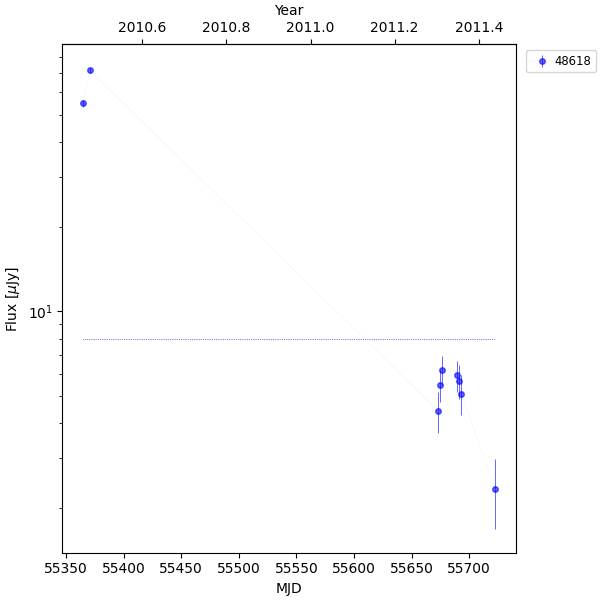

In [3]:
# αJ2000 = 16h09min28.296s, δJ2000 = +53 deg 40′ 23.52′′ from arXiv:1205.0252 in field "GNU2597664528044916736"
#logger.enable("vasca")

src_ps1tde, dist = rg.get_src_from_sky_pos('16h09m28.296s', '+53d40m23.52s')
print("Found VASCA source is at distance:",dist.degree,"deg")

fig_lc, ax_lc = vvis.plot_light_curve(src_ps1tde,rg_src_ids=src_ps1tde.tt_sources["rg_src_id"][0])
display(src_ps1tde.tt_fields)
display(src_ps1tde.tt_sources)
display(src_ps1tde.tt_detections)

### Display TDE PS1-10jh field in the sky

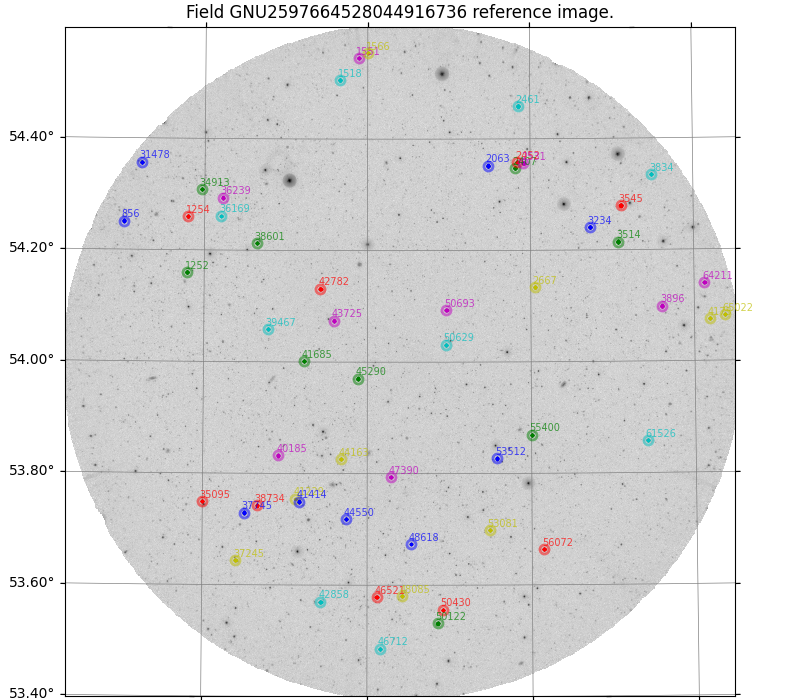

In [4]:
fd = rg.get_field(field_id=src_ps1tde.tt_fields[0]["field_id"], load_method="FITS", add_field=True)
fd_src_id = src_ps1tde.tt_fields["fd_src_id"][0]

fig, ax = vvis.plot_field_sky_map(fd, img_idx=-1, sky_region = fd.get_sky_region()) # 
ax = vvis.plot_sky_sources(rg.tt_sources,tt_det=rg.tt_detections, sky_region_wcs = (fd.get_sky_region(),fd.ref_wcs)) # 
#display(Table(fd.tt_sources[src_idx]))

### Show TDS coverage maps

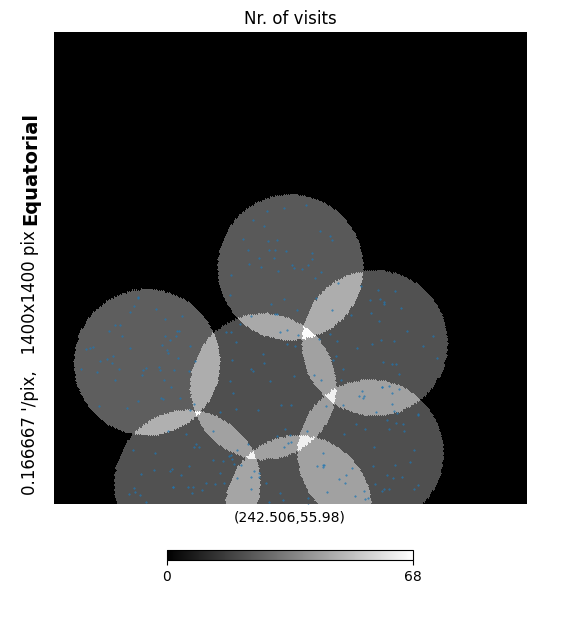

In [5]:
#logger.enable("vasca")
plot_coverage = True
if plot_coverage:
    rg.add_coverage_hp(nside=4096, coord_sys="icrs")
    #vvis.plot_region_sky_mollview(rg, var="nr_vis")
    #vvis.plot_region_sky_mollview(rg, var="nr_fds")
    #vvis.plot_region_sky_mollview(rg, var="exp")
    #rg.add_coverage_hp(nside=4096, )
    vvis.plot_region_sky_gnomeview(rg,rg.tt_fields[0]["ra"],rg.tt_fields[0]["dec"])
    #vvis.plot_region_sky_mollview(rg)

### Sky image with Imviz, show source and detection markers on-top

In [6]:
show_imviz = False
if show_imviz:
    hdup = fits.PrimaryHDU(fd.ref_img, header=fd.ref_wcs.to_header())
    imviz = Imviz()
    viewer = imviz.default_viewer
    imviz.load_data(hdup, data_label=str(field_id))
    imviz.show(loc='sidecar')

    sel_det = fd.tt_detections["sel"]
    tt_det_sky = Table({'coord': SkyCoord(fd.tt_detections[sel_det]["ra"], fd.tt_detections[sel_det]["dec"], frame='fk5')})
    viewer.marker = {'color':'blue', 'markersize': 5., 'fill': False} #, 'alpha': 1.0
    viewer.add_markers(tt_det_sky, use_skycoord=True, marker_name='D')

    srcs_sky = SkyCoord(fd.tt_sources["ra"], fd.tt_sources["dec"], frame='fk5')
    tt_srcs_sky = Table({'coord':srcs_sky })
    viewer.marker = {'color':'red', 'markersize': 2., 'fill': True} #, 'alpha': 1.0
    viewer.add_markers(tt_srcs_sky, use_skycoord=True, marker_name='S')

### Show TDS diagnostic plots
#### Source parameters distributions

Total / selected sources: 294 / 46900 ( 0.63 %)


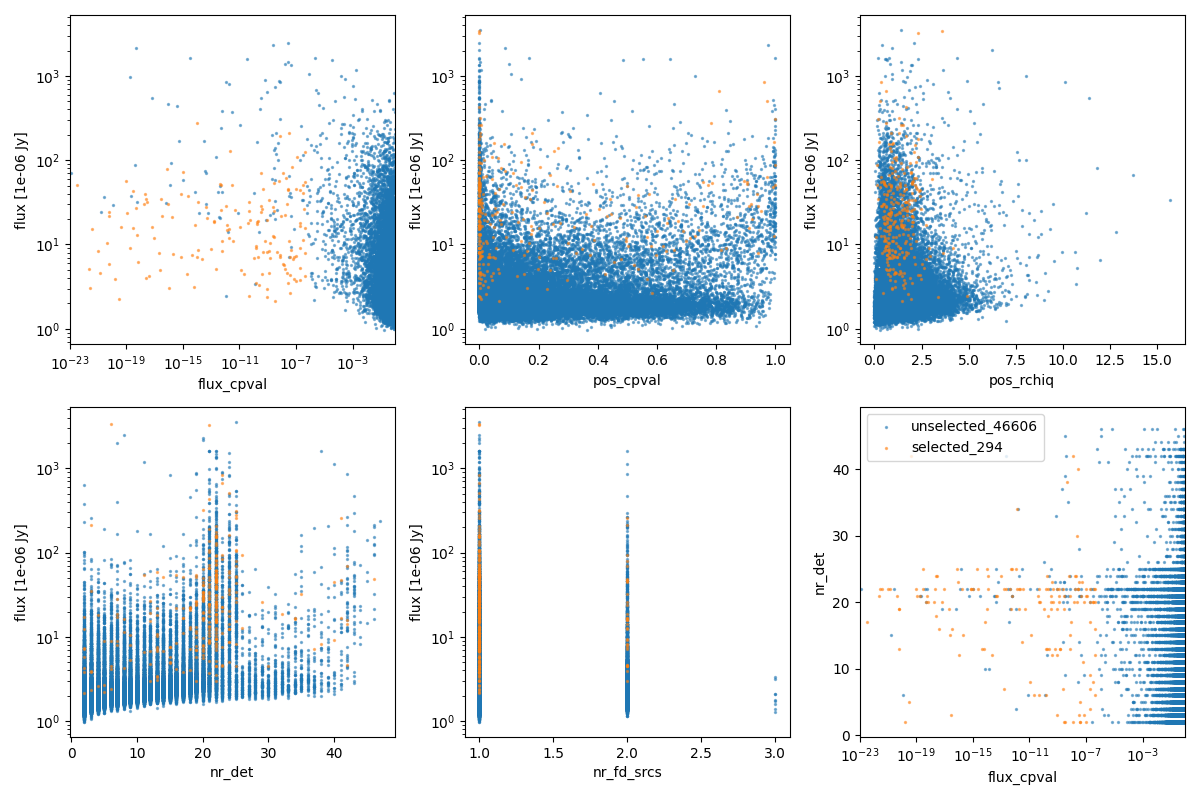

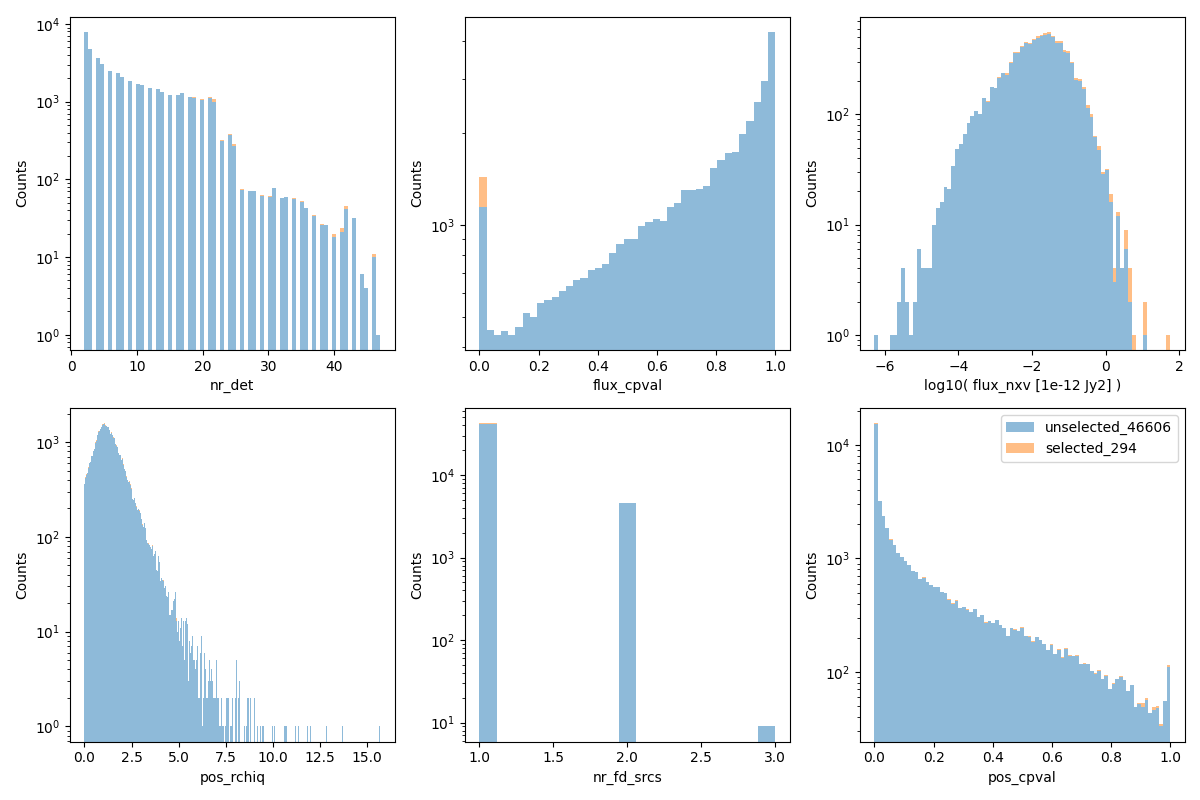

In [7]:
fig_fd_det_diag_scat = vvis.plot_pipe_diagnostic(rg, "tt_sources", "scatter")
fig_rg_src_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(rg, "tt_sources", "hist")
sel= rg.tt_sources["sel"]
nr_sel_srcs =len(rg.tt_sources[sel])
nr_srcs = len(rg.tt_sources)
print("Total / selected sources:",nr_sel_srcs,"/",nr_srcs,"(",np.round(100*nr_sel_srcs/nr_srcs,2),"%)")

#### Display distribution for all detections in the field of TDE PS1-10jh

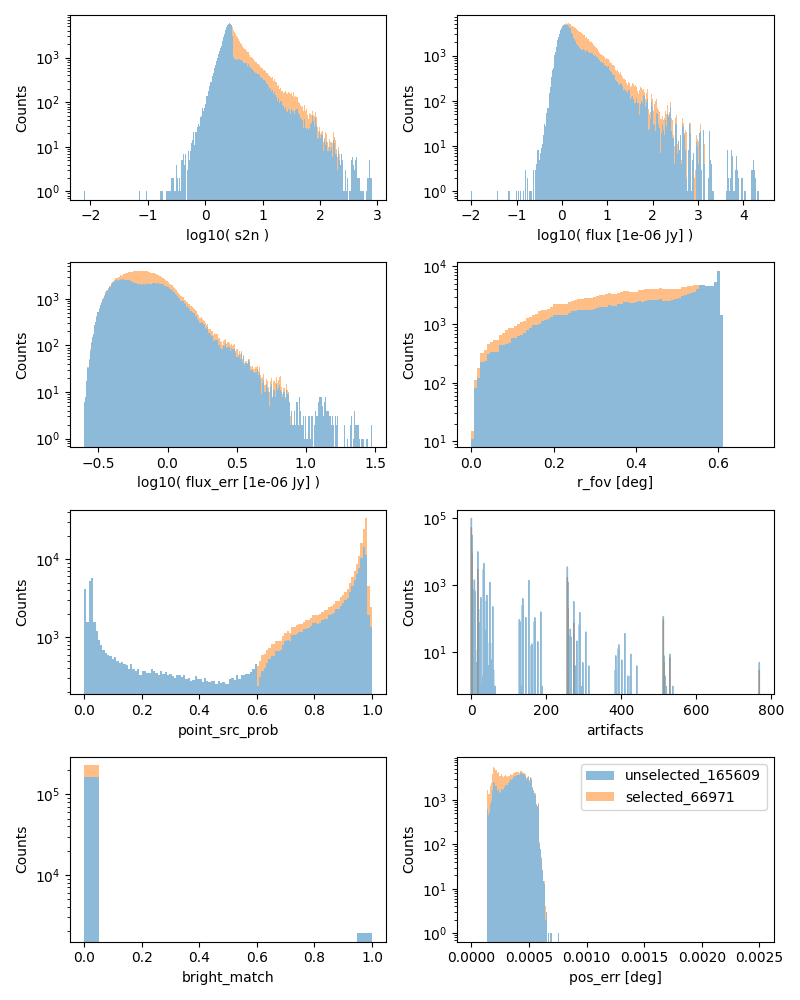

In [8]:
fig_det_diag_hist, plot_pars = vvis.plot_pipe_diagnostic(fd, "tt_detections", "hist",fig_size=(8, 10))

### Look into more details for the chisquare distribution

Text(0.5, 0, 'Reduced chisquare')

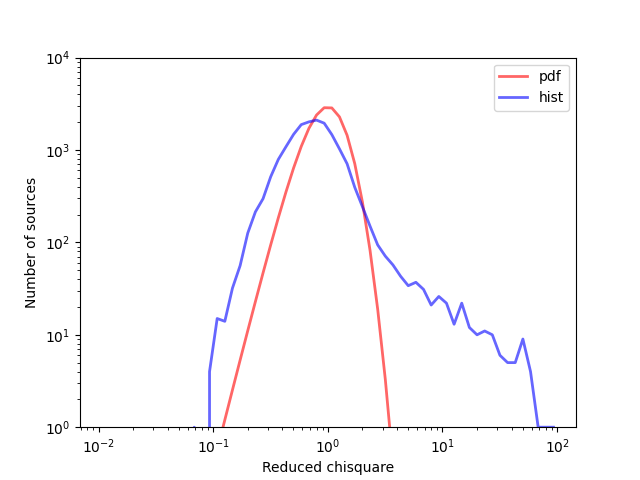

In [9]:
#Setup binning
rchisq_bins_lg = np.linspace(-2, 2, 61)
rchisq_bins = np.power(10,rchisq_bins_lg)
rchisq_bins_mean = (rchisq_bins[:-1]+rchisq_bins[1:])/2.
rchisq_bins_width = rchisq_bins[1:]-rchisq_bins[:-1]

#Select events
sel_det = rg.tt_sources["nr_det"]>10

#Calculate expected rchiq distribution for selected events
rchsq_pdf = np.zeros(len(rchisq_bins_mean))
#Get summed reduced chisquare distribution
for src in rg.tt_sources[sel_det]:
    rchsq_pdf += chi2.pdf(rchisq_bins_mean, src["nr_det"]-1, scale = 1/(src["nr_det"]-1) )*rchisq_bins_width 

rchiq_hist, bins = np.histogram(rg.tt_sources[sel_det]["flux_rchiq"], bins = rchisq_bins)

fig_rchsq = plt.figure()
plt.loglog(rchisq_bins_mean, rchsq_pdf ,'r-', lw=2, alpha=0.6, label='pdf')
plt.loglog(rchisq_bins_mean, rchiq_hist ,'b-', lw=2, alpha=0.6, label='hist')
plt.ylim(1e-0,1e4)
plt.legend()
plt.ylabel("Number of sources")
plt.xlabel("Reduced chisquare")

### Look at the Pval distibutions for constant flux and position for different magnitudes

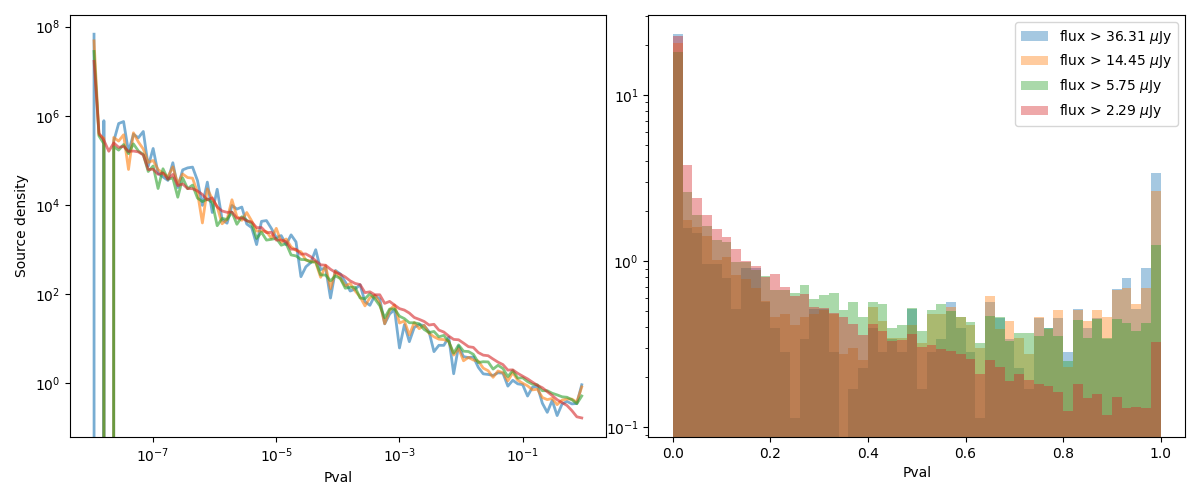

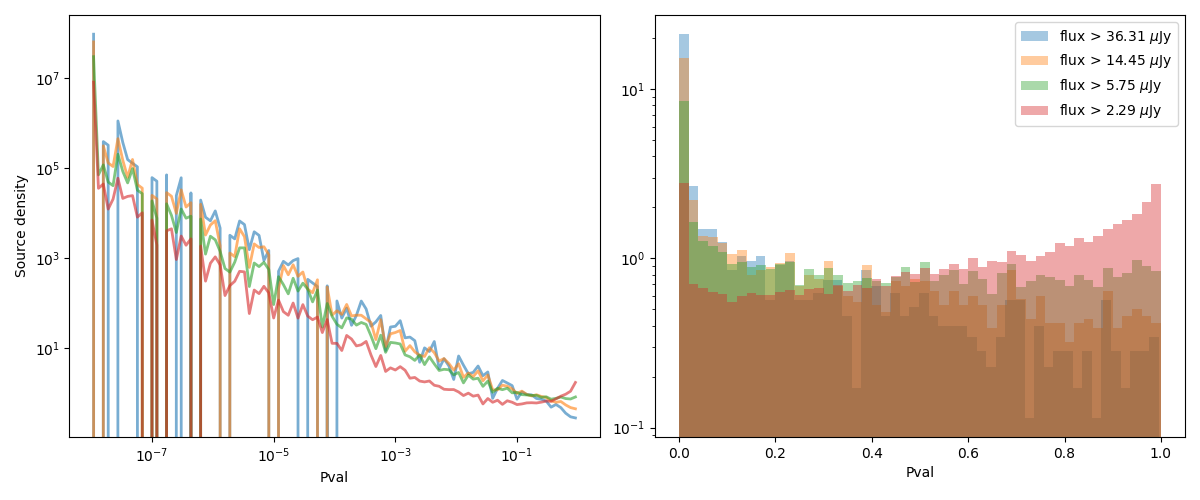

In [10]:
#Get pval data and saturate it at low Pval for better plotting
var_cpval = ["pos","flux"] #"pos" # 
pval_min = 1e-8
for var in var_cpval:
    pvals = rg.tt_sources[var+"_cpval"]
    pvals = (pvals<pval_min+1e-12)*(pval_min+1e-12)+(pvals>pval_min)*pvals

    #if plot_logx:
    pval_bins_lg = np.linspace(np.log10(pval_min), 0, 101)
    pval_bins = np.power(10,pval_bins_lg)
    pval_bins_mean = (pval_bins[:-1]+pval_bins[1:])/2.

    #Plotting for different magnitude cuts
    fig_pval, axs = plt.subplots(1, 2, figsize=(12, 5), squeeze=False, num=var)
    axs = axs.flatten()
    flux_range = mag2flux(range(20,24))
    for flux_cut in flux_range:
        sel_flux = (rg.tt_sources["flux"]>flux_cut)

        pval_hist, bins = np.histogram(pvals[sel_flux], bins=pval_bins, density=True)
        axs[0].loglog(pval_bins_mean, pval_hist , lw=2, alpha=0.6, label=str(flux_cut))
        str_cut = str(round(flux_cut.value*1e6,2)) 
        axs[1].hist(rg.tt_sources[sel_flux][var+"_cpval"], bins=50, density=True ,label=r"flux > "+str_cut+" $\mu$Jy",alpha=0.4)   #, ,cumulative=1


    axs[0].set_ylabel("Source density")
    axs[0].set_xlabel("Pval")
    axs[1].set_xlabel("Pval")
    plt.legend()
    plt.tight_layout()
    plt.semilogy()

### Reproduce Fig. 3 from Gezari et al. ApJ 2013

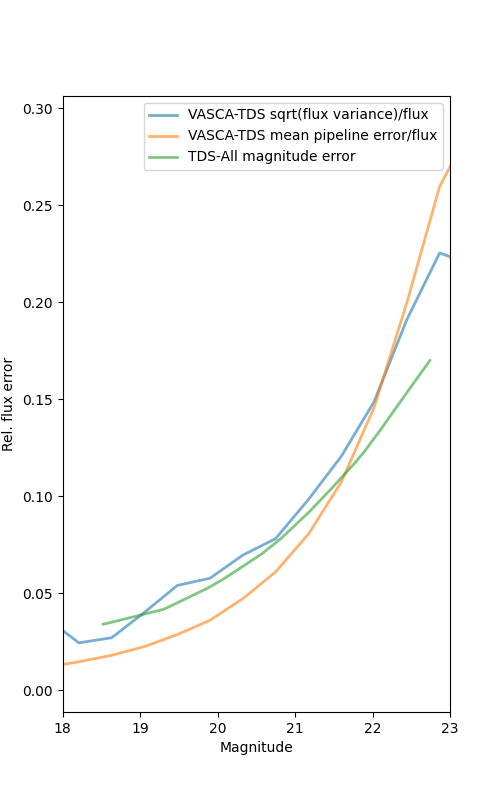

In [11]:
#Source selection
sel_cpval = rg.tt_sources["flux_cpval"]>-1
#rg.tt_fields.add_index("field_id")
#fd = rg.tt_fields.loc["field_id", "GNU2605053246158405632"]
#sel_field = rg.tt_sources["rg_fd_id"]==fd["rg_fd_id"]
sel_ndet = rg.tt_sources["nr_det"]>10
sel_all = sel_cpval*sel_ndet#*sel_field

flux_var_wght = np.sqrt(rg.tt_sources["flux_var"][sel_all])/rg.tt_sources["flux"][sel_all]
flux_var_hist, var_bins = np.histogram(rg.tt_sources["mag"][sel_all], bins=20, density=False, weights = flux_var_wght )
flux_rel_err_wght = rg.tt_sources["flux_err"][sel_all]*np.sqrt(rg.tt_sources["nr_det"][sel_all])/rg.tt_sources["flux"][sel_all]
flux_relerr_hist, var_bins = np.histogram(rg.tt_sources["mag"][sel_all], bins=var_bins, density=False, weights = flux_rel_err_wght)
flux_var_entries, bins = np.histogram(rg.tt_sources["mag"][sel_all], bins=var_bins, density=False)
var_bins_mean = (var_bins[:-1]+var_bins[1:])/2.

#Get TDS Fig 3 data
tt_tds= Table.read("./TDS-ApJ_766_60/GezariApJ2013_TDS_Fig3.csv")

#Plot
fig_mag_var = plt.figure(figsize=(5, 8))
plt.plot(var_bins_mean , flux_var_hist/flux_var_entries ,lw=2, alpha=0.6, label="VASCA-TDS sqrt(flux variance)/flux")
plt.plot(var_bins_mean , flux_relerr_hist/flux_var_entries ,lw=2, alpha=0.6, label="VASCA-TDS mean pipeline error/flux")
#plt.plot(tt_tds["mag"] , tt_tds["MOS23"] ,lw=2, alpha=0.6, label="TDS-MOS23")
plt.plot(tt_tds["mag"] , tt_tds["TDS"] ,lw=2, alpha=0.6, label="TDS-All magnitude error")
plt.xlabel("Magnitude")
plt.ylabel("Rel. flux error")
plt.legend()
plt.xlim([18, 23])
fig_mag_var.savefig("./vasca_pipeline/"+region_name+"/vasca_"+region_name+"_mag_err.png")
#plt.semilogy()

In [12]:
### Angular resolution comparison distribution to errors

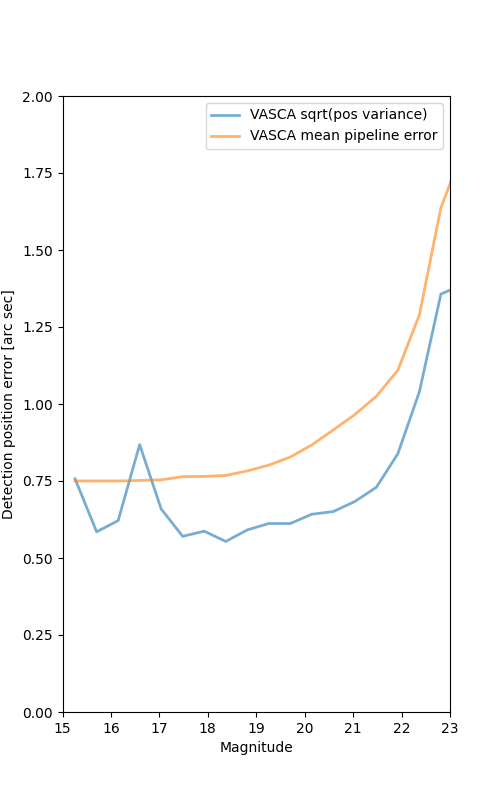

In [13]:
#Source selection
sel_cpval = rg.tt_sources["flux_cpval"]>0.01
#sel_field = rg.tt_sources["rg_fd_id"]==fd["rg_fd_id"]
sel_ndet = rg.tt_sources["nr_det"]>10
sel_all = np.ones(len(rg.tt_sources),dtype=bool) # sel_cpval*sel_ndet*sel_field

pos_var_hist, var_bins = np.histogram(rg.tt_sources["mag"][sel_all], bins=20, density=False, weights = np.sqrt(rg.tt_sources["pos_var"][sel_all]) )
pos_err_hist, var_bins = np.histogram(rg.tt_sources["mag"][sel_all], bins=20, density=False, weights = rg.tt_sources["pos_err"][sel_all]*np.sqrt(rg.tt_sources["nr_det"][sel_all]))
pos_var_entries, bins = np.histogram(rg.tt_sources["mag"][sel_all], bins=var_bins, density=False)
pos_bins_mean = (var_bins[:-1]+var_bins[1:])/2.

#Plot
fig_pos_var = plt.figure(figsize=(5, 8))
plt.plot(pos_bins_mean , 3600*pos_var_hist/pos_var_entries ,lw=2, alpha=0.6, label="VASCA sqrt(pos variance)")
plt.plot(pos_bins_mean , 3600*pos_err_hist/pos_var_entries ,lw=2, alpha=0.6, label="VASCA mean pipeline error")
plt.xlabel("Magnitude")
plt.ylabel("Detection position error [arc sec]")
plt.legend()
plt.xlim([15, 23])
plt.ylim([0, 2.0])
fig_pos_var.savefig("./vasca_pipeline/"+region_name+"/vasca_"+region_name+"_pos_err.png")
#plt.semilogy()

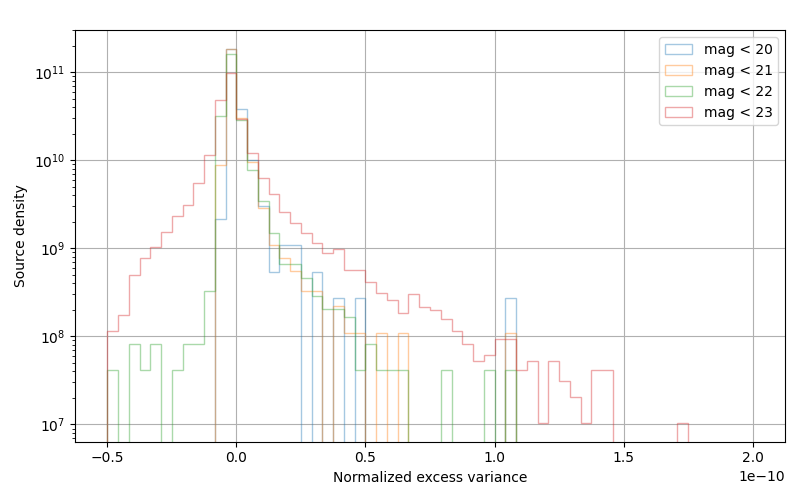

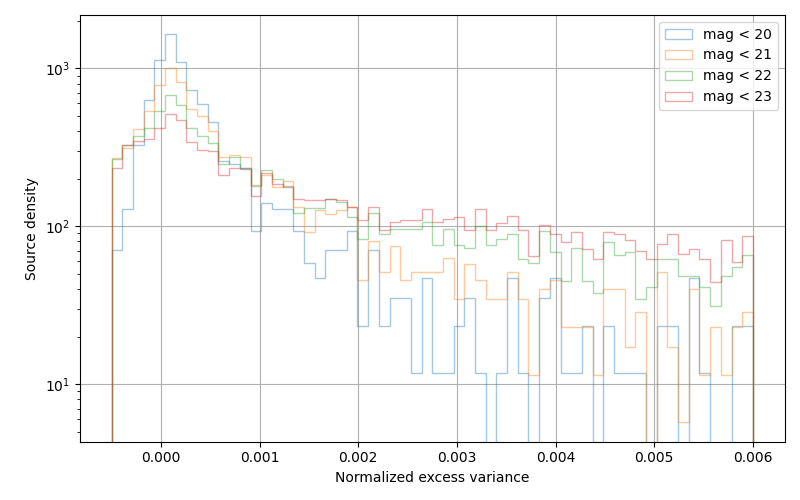

In [14]:
var_nxv = ["pos","flux"] #"pos" # 
nxv_bins = {"pos":np.linspace(-0.5e-10, 2e-10, 61),
            "flux":np.linspace(-0.0005, 0.006, 61)}

for var in var_nxv:
    # Plot excess variance for different magnitude levels
    fig_flux_nxv = plt.figure(num=var+"_nxv",figsize=(8, 5))
    for mag_cut in range(20,24):
        sel_mag = (rg.tt_sources["mag"]<mag_cut) 
        plt.hist(rg.tt_sources[sel_mag][var+"_nxv"], bins=nxv_bins[var], density=True ,label="mag < "+str(mag_cut),alpha=0.4, histtype="step")   #, ,cumulative=1
    plt.ylabel("Source density")
    plt.xlabel("Normalized excess variance")
    plt.legend()
    plt.tight_layout()
    plt.semilogy()
    plt.grid()
    plt.show()